# GPS bearing analysis

Testing if the bearing angle and the calculated bearing are at all representative of the direction the phone is pointed in.

Bearing Comparison:
                 time_from_sync    Bearing  Calculated_Bearing  \
1 1970-01-01 00:00:00.000000791  297.31705          296.283409   
2 1970-01-01 00:00:00.000000792  297.38605          302.299221   
3 1970-01-01 00:00:00.000000793  297.88830          296.283462   
4 1970-01-01 00:00:00.000000794  298.39542          297.780122   
5 1970-01-01 00:00:00.000000795  299.04540          302.299309   

   Bearing_Difference  
1            1.102641  
2            4.410921  
3            2.111958  
4            1.265278  
5            3.280179  

Summary Statistics of Bearing Differences:
count    128.000000
mean       9.266889
std        4.741845
min        0.018334
25%        5.987496
50%        9.445415
75%       12.339435
max       20.514183
Name: Bearing_Difference, dtype: float64

Detailed comparison saved to bearing_comparison.csv


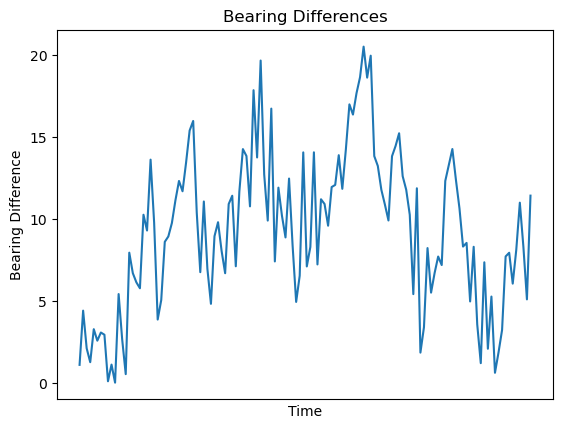

In [6]:
import pandas as pd
import numpy as np

# Function to calculate bearing between two points
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing between two points on the Earth.
    Parameters:
        lat1, lon1: Latitude and Longitude of point 1 in decimal degrees
        lat2, lon2: Latitude and Longitude of point 2 in decimal degrees
    Returns:
        Bearing in degrees from point 1 to point 2
    """
    # Convert from degrees to radians
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    delta_lon = lon2_rad - lon1_rad
    x = np.sin(delta_lon) * np.cos(lat2_rad)
    y = (np.cos(lat1_rad) * np.sin(lat2_rad) -
         np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(delta_lon))
    
    initial_bearing = np.arctan2(x, y)
    # Convert from radians to degrees and normalize to 0-360
    initial_bearing_deg = (np.degrees(initial_bearing) + 360) % 360
    return initial_bearing_deg

# Path to your CSV file
csv_file_path = 'GPS/GPS_007_Fast_stbd_turn_1.csv'  # Replace with your actual file path

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Ensure the data is sorted by time. Adjust the 'Time' column format if necessary.
# Assuming 'Time' is in a format that pandas can parse
df['time_from_sync'] = pd.to_datetime(df['time_from_sync'])
df = df.sort_values('time_from_sync').reset_index(drop=True)

# Shift the latitude and longitude to get previous points
df['Prev_Lat'] = df['Lat'].shift(1)
df['Prev_Lng'] = df['Lng'].shift(1)

# Calculate the bearing from the previous point to the current point
df['Calculated_Bearing'] = calculate_bearing(
    df['Prev_Lat'],
    df['Prev_Lng'],
    df['Lat'],
    df['Lng']
)

# Since the first row has no previous point, it will have NaN
# Compare the calculated bearing to the recorded 'Bearing'
# Depending on the definition, you might need to shift 'Bearing' as well
# Here, we assume 'Bearing' at point i corresponds to movement from i to i+1
# So we compare 'Bearing' at i to 'Calculated_Bearing' at i+1

df['Bearing_Shifted'] = df['Bearing'].shift(-1)

# Calculate the difference
df['Bearing_Difference'] = (df['Calculated_Bearing'] - df['Bearing_Shifted']).abs()

# Adjust differences to be within [0, 180]
df['Bearing_Difference'] = df['Bearing_Difference'].apply(lambda x: min(x, 360 - x) if pd.notnull(x) else x)

# Display some comparison results
print("Bearing Comparison:")
print(df[['time_from_sync', 'Bearing', 'Calculated_Bearing', 'Bearing_Difference']].dropna().head())

# Summary statistics
print("\nSummary Statistics of Bearing Differences:")
print(df['Bearing_Difference'].describe())

# Optionally, save the comparison to a new CSV
output_file_path = 'bearing_comparison.csv'
df.to_csv(output_file_path, index=False)
print(f"\nDetailed comparison saved to {output_file_path}")

# Optionally, plot the differences
import matplotlib.pyplot as plt
plt.plot(df['time_from_sync'], df['Bearing_Difference'])
plt.xlabel('Time')
plt.ylabel('Bearing Difference')
plt.title('Bearing Differences')
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to convert bearing to vector components
def bearing_to_vector(bearing_deg):
    """
    Convert bearing in degrees to vector components (u, v).
    Bearing is measured in degrees clockwise from North.
    """
    bearing_rad = np.deg2rad(bearing_deg)
    # Convert bearing to mathematical angle (counter-clockwise from East)
    angle_rad = np.pi/2 - bearing_rad
    angle_rad = np.mod(angle_rad, 2 * np.pi)
    u = np.cos(angle_rad)
    v = np.sin(angle_rad)
    return u, v

# Path to your CSV file
csv_file_path = '2024-11-04_161834_90_degrees_test.csv'  # Replace with your actual file path

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Optional: Sort the data by time to ensure chronological order
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time').reset_index(drop=True)

# Extract necessary columns
required_columns = ['Lat', 'Lng', 'Bearing']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not found in the CSV file.")

# Drop rows with missing values in required columns
df = df.dropna(subset=required_columns).reset_index(drop=True)

# Optional: Downsample the data for better visualization if the dataset is large
# For example, aim for around 1000 arrows
max_arrows = 1000
step = max(1, len(df) // max_arrows)
df_plot = df.iloc[::step, :]

# Convert bearing to vector components
u, v = bearing_to_vector(df_plot['Bearing'])

# Apply scaling to longitude to account for latitude
# This ensures that the horizontal scaling reflects actual distances
df_plot['Lng_scaled'] = df_plot['Lng'] * np.cos(np.deg2rad(df_plot['Lat']))

# Create the quiver plot
plt.figure(figsize=(12, 8))
quiver = plt.quiver(
    df_plot['Lng_scaled'], 
    df_plot['Lat'], 
    u, 
    v, 
    df_plot['Bearing'],
    cmap='hsv',
    scale=50,       # Adjust scale for arrow length
    width=0.002,    # Adjust width for arrow thickness
    headwidth=3,
    headlength=4
)

plt.xlabel('Longitude (scaled)')
plt.ylabel('Latitude')
plt.title('Quiver Plot of Bearings over Geographic Locations')

# Add a color bar to indicate bearing angles
cbar = plt.colorbar(quiver)
cbar.set_label('Bearing (degrees)')

# Set aspect ratio to equal to maintain correct scaling
plt.gca().set_aspect('equal', adjustable='box')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()




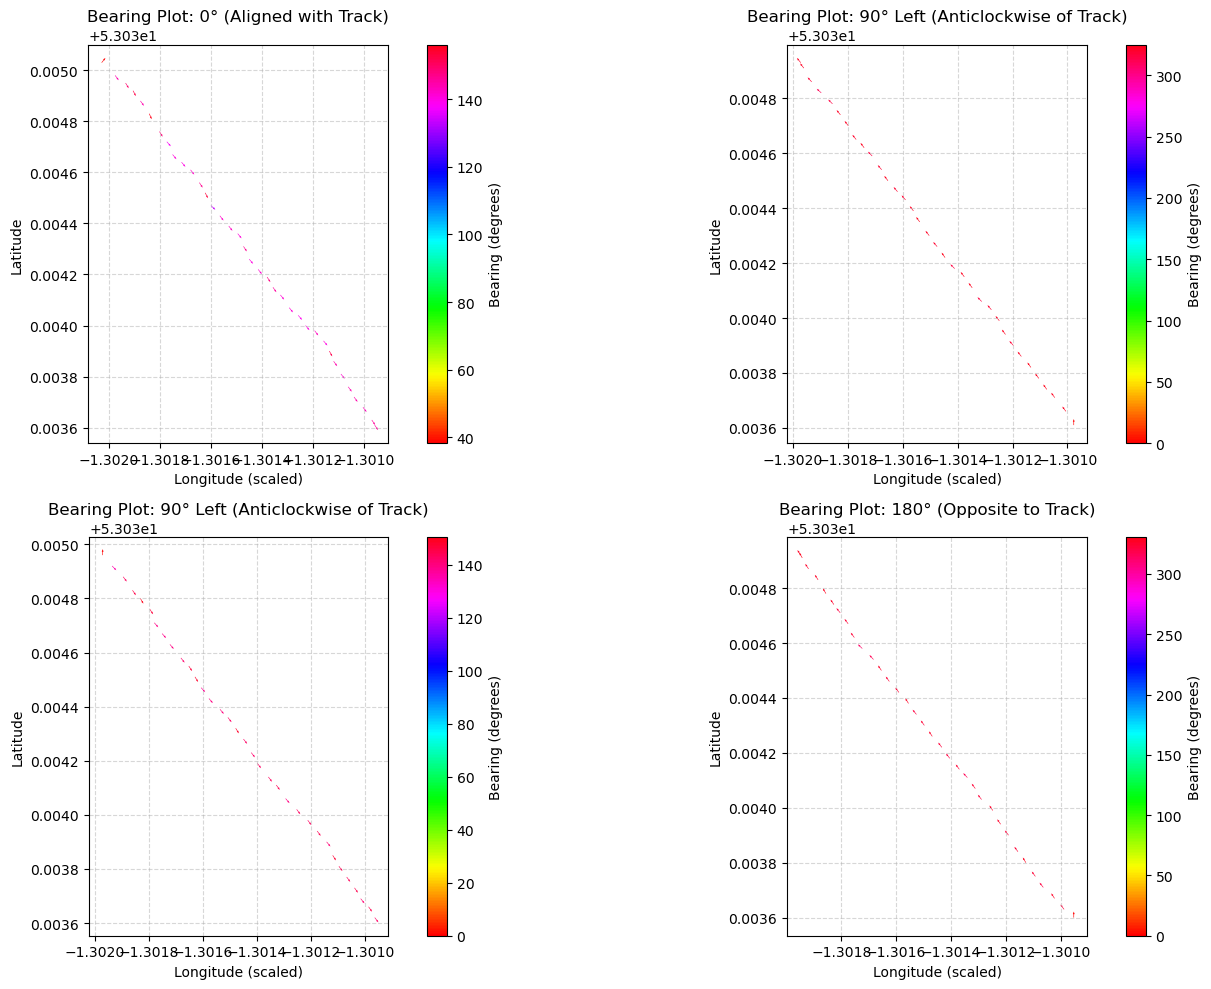

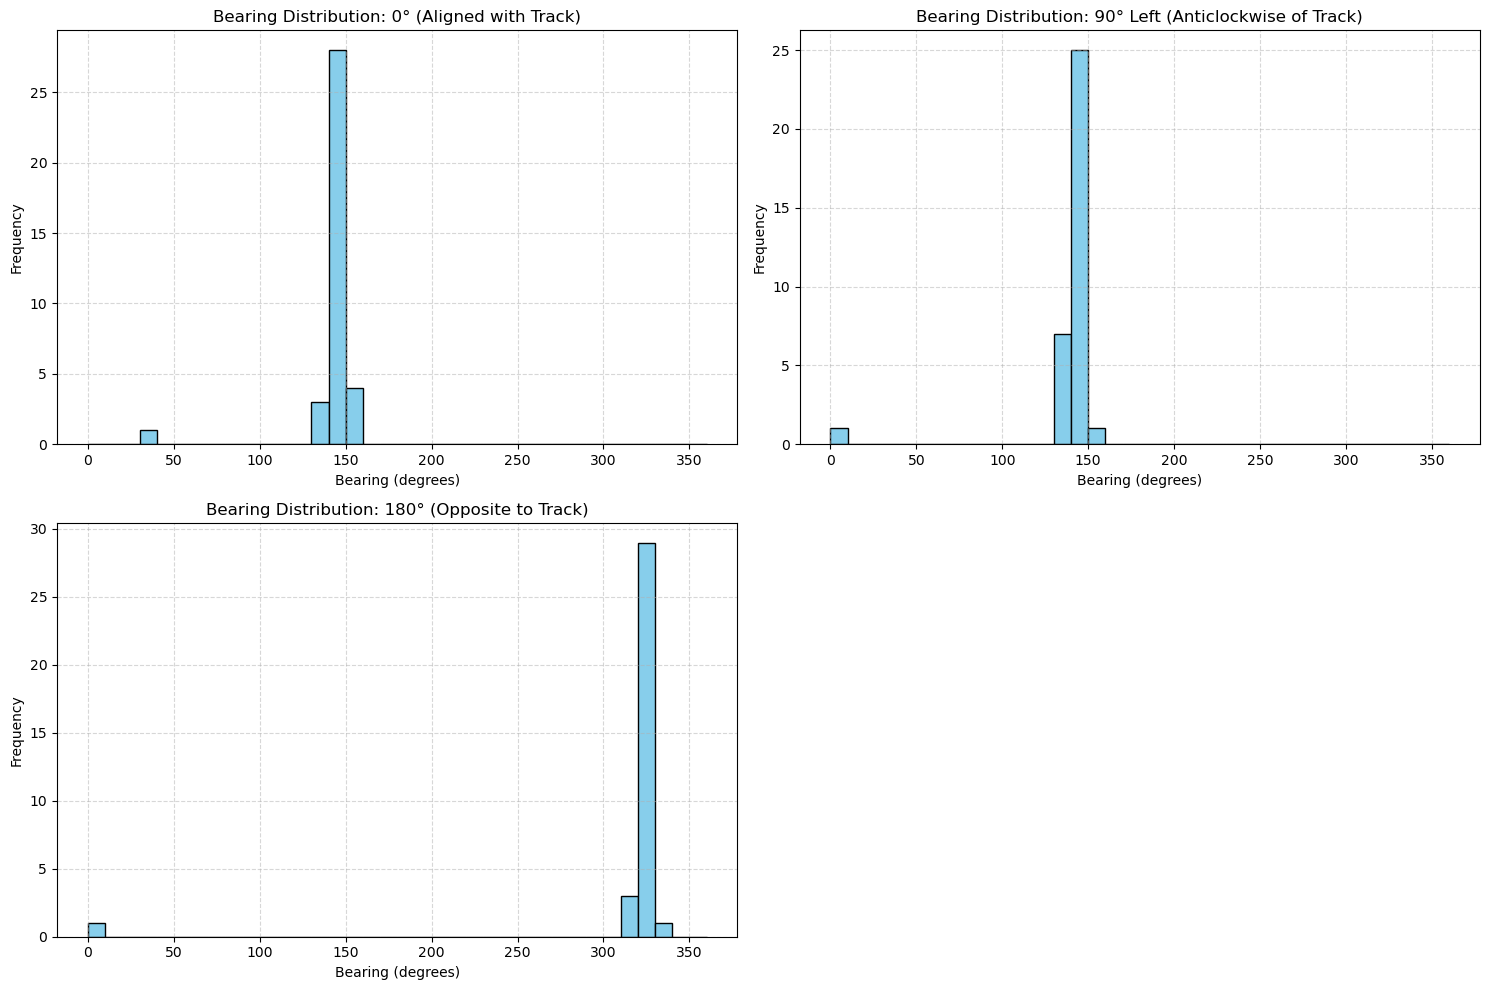

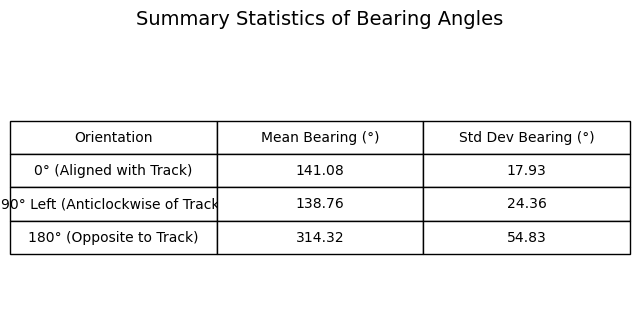

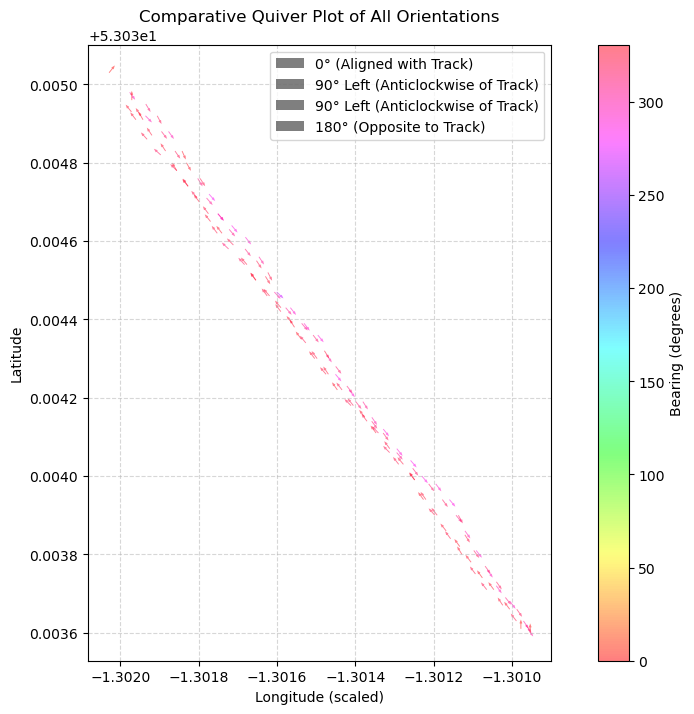

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to convert bearing to vector components
def bearing_to_vector(bearing_deg):
    """
    Convert bearing in degrees to vector components (u, v).
    Bearing is measured in degrees clockwise from North.
    """
    bearing_rad = np.deg2rad(bearing_deg)
    # Convert bearing to mathematical angle (counter-clockwise from East)
    angle_rad = np.pi/2 - bearing_rad
    angle_rad = np.mod(angle_rad, 2 * np.pi)
    u = np.cos(angle_rad)
    v = np.sin(angle_rad)
    return u, v

# List of CSV files and their orientations
files_orientations = {
    '0_degrees_out.csv': '0° (Aligned with Track)',
    '90_degree_left_return.csv': '90° Left (Anticlockwise of Track)',
    '90_degrees_left_out.csv': '90° Left (Anticlockwise of Track)',
    '180_degrees_return.csv': '180° (Opposite to Track)'
}

# Path to your CSV files directory
csv_directory = '.'  # Replace with your actual directory if different

# Parameters for plotting
max_arrows = 1000
scale = 50
width = 0.002
headwidth = 3
headlength = 4

# Initialize lists to store data for additional visualizations
bearing_data = {}
summary_stats = {}

# Create a figure with subplots for quiver plots
num_files = len(files_orientations)
cols = 2
rows = (num_files + 1) // cols
fig_quiver, axes_quiver = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes_quiver = axes_quiver.flatten()

for idx, (filename, orientation) in enumerate(files_orientations.items()):
    file_path = os.path.join(csv_directory, filename)
    
    if not os.path.isfile(file_path):
        print(f"File '{filename}' not found in directory '{csv_directory}'. Skipping.")
        continue
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Optional: Sort the data by time to ensure chronological order
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'])
        df = df.sort_values('Time').reset_index(drop=True)
    
    # Extract necessary columns
    required_columns = ['Lat', 'Lng', 'Bearing']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the CSV file '{filename}'.")
    
    # Drop rows with missing values in required columns
    df = df.dropna(subset=required_columns).reset_index(drop=True)
    
    # Optional: Downsample the data for better visualization if the dataset is large
    step = max(1, len(df) // max_arrows)
    df_plot = df.iloc[::step, :]
    
    # Convert bearing to vector components
    u, v = bearing_to_vector(df_plot['Bearing'].values)
    
    # Apply scaling to longitude to account for latitude
    df_plot['Lng_scaled'] = df_plot['Lng'] * np.cos(np.deg2rad(df_plot['Lat']))
    
    # Store bearing data for additional visualizations
    bearing_data[orientation] = df_plot['Bearing'].values
    
    # Calculate summary statistics
    summary_stats[orientation] = {
        'Mean Bearing': np.mean(df_plot['Bearing']),
        'Std Bearing': np.std(df_plot['Bearing'])
    }
    
    # Create the quiver plot
    ax = axes_quiver[idx]
    quiver = ax.quiver(
        df_plot['Lng_scaled'], 
        df_plot['Lat'], 
        u, 
        v, 
        df_plot['Bearing'],
        cmap='hsv',
        scale=scale,       # Adjust scale for arrow length
        width=width,       # Adjust width for arrow thickness
        headwidth=headwidth,
        headlength=headlength
    )
    
    ax.set_xlabel('Longitude (scaled)')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Bearing Plot: {orientation}')
    
    # Add a color bar to indicate bearing angles
    cbar = fig_quiver.colorbar(quiver, ax=ax)
    cbar.set_label('Bearing (degrees)')
    
    # Set aspect ratio to equal to maintain correct scaling
    ax.set_aspect('equal', adjustable='box')
    
    # Show grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(idx + 1, len(axes_quiver)):
    fig_quiver.delaxes(axes_quiver[j])

plt.tight_layout()
plt.show()

# Additional Visualization: Bearing Distribution Histograms
fig_hist, axes_hist = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes_hist = axes_hist.flatten()

for idx, (orientation, bearings) in enumerate(bearing_data.items()):
    ax = axes_hist[idx]
    ax.hist(bearings, bins=36, range=(0, 360), color='skyblue', edgecolor='black')
    ax.set_title(f'Bearing Distribution: {orientation}')
    ax.set_xlabel('Bearing (degrees)')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(idx + 1, len(axes_hist)):
    fig_hist.delaxes(axes_hist[j])

plt.tight_layout()
plt.show()

# Additional Visualization: Summary Statistics Table
import matplotlib.table as tbl

fig_table, ax_table = plt.subplots(figsize=(8, 2 + len(summary_stats) * 0.5))
ax_table.axis('off')  # Hide the axes

# Prepare table data
table_data = []
for orientation, stats in summary_stats.items():
    table_data.append([orientation, f"{stats['Mean Bearing']:.2f}", f"{stats['Std Bearing']:.2f}"])

# Define table column labels
column_labels = ["Orientation", "Mean Bearing (°)", "Std Dev Bearing (°)"]

# Create the table using the Axes method
table = ax_table.table(cellText=table_data,
                       colLabels=column_labels,
                       loc='center',
                       cellLoc='center')

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.title('Summary Statistics of Bearing Angles', fontsize=14, pad=20)
plt.show()

# Optional: Comparative Quiver Plot Overlay
fig_comparative, ax_comparative = plt.subplots(figsize=(12, 8))

for filename, orientation in files_orientations.items():
    file_path = os.path.join(csv_directory, filename)
    if not os.path.isfile(file_path):
        print(f"File '{filename}' not found in directory '{csv_directory}'. Skipping.")
        continue
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Optional: Sort the data by time to ensure chronological order
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'])
        df = df.sort_values('Time').reset_index(drop=True)
    
    # Extract necessary columns
    required_columns = ['Lat', 'Lng', 'Bearing']
    for col in required_columns:
        if col not in df.columns:
            print(f"Required column '{col}' not found in the CSV file '{filename}'. Skipping.")
            continue
    
    # Drop rows with missing values in required columns
    df = df.dropna(subset=required_columns).reset_index(drop=True)
    
    # Optional: Downsample the data for better visualization if the dataset is large
    step = max(1, len(df) // max_arrows)
    df_plot = df.iloc[::step, :]
    
    # Convert bearing to vector components
    u, v = bearing_to_vector(df_plot['Bearing'].values)
    
    # Apply scaling to longitude to account for latitude
    df_plot['Lng_scaled'] = df_plot['Lng'] * np.cos(np.deg2rad(df_plot['Lat']))
    
    # Plot quiver with transparency to avoid clutter
    quiver = ax_comparative.quiver(
        df_plot['Lng_scaled'], 
        df_plot['Lat'], 
        u, 
        v, 
        df_plot['Bearing'],
        cmap='hsv',
        scale=scale,       # Adjust scale for arrow length
        width=width,       # Adjust width for arrow thickness
        headwidth=headwidth,
        headlength=headlength,
        alpha=0.5,
        label=orientation
    )

# Add a single color bar for the combined plot
cbar_comparative = fig_comparative.colorbar(quiver, ax=ax_comparative)
cbar_comparative.set_label('Bearing (degrees)')

ax_comparative.set_xlabel('Longitude (scaled)')
ax_comparative.set_ylabel('Latitude')
ax_comparative.set_title('Comparative Quiver Plot of All Orientations')
ax_comparative.legend()
ax_comparative.grid(True, linestyle='--', alpha=0.5)
ax_comparative.set_aspect('equal', adjustable='box')
plt.show()


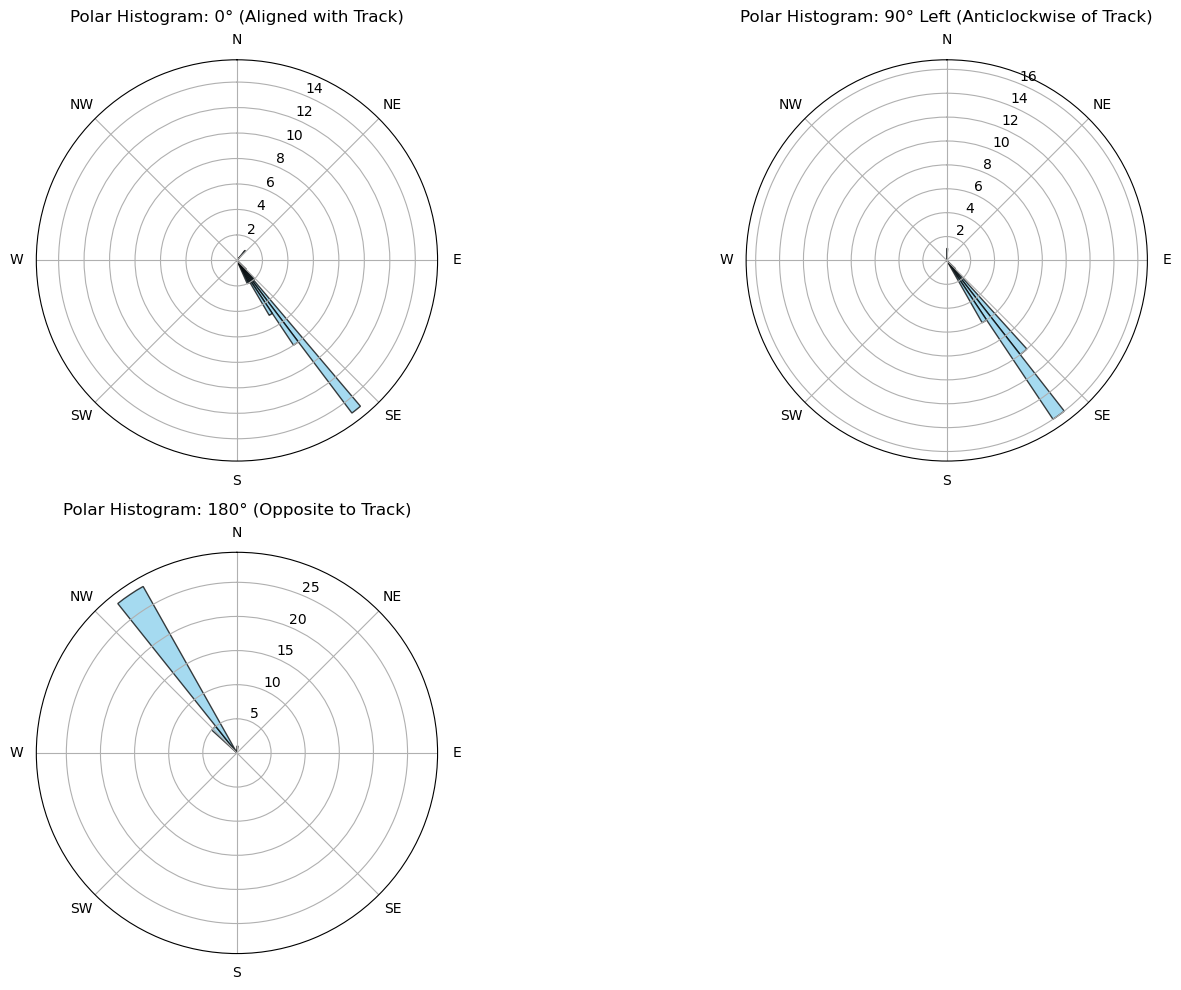

In [3]:
fig_polar, axes_polar = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(15, 5 * rows))
axes_polar = axes_polar.flatten()

for idx, (orientation, bearings) in enumerate(bearing_data.items()):
    ax = axes_polar[idx]
    ax.hist(np.deg2rad(bearings), bins=36, color='skyblue', edgecolor='black', alpha=0.75)
    ax.set_title(f'Polar Histogram: {orientation}', va='bottom')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

# Hide any unused subplots
for j in range(idx + 1, len(axes_polar)):
    fig_polar.delaxes(axes_polar[j])

plt.tight_layout()
plt.show()


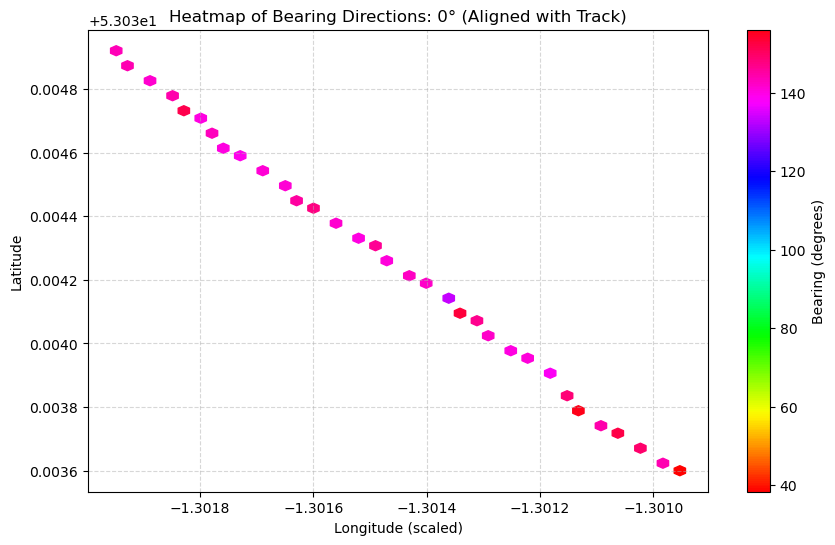

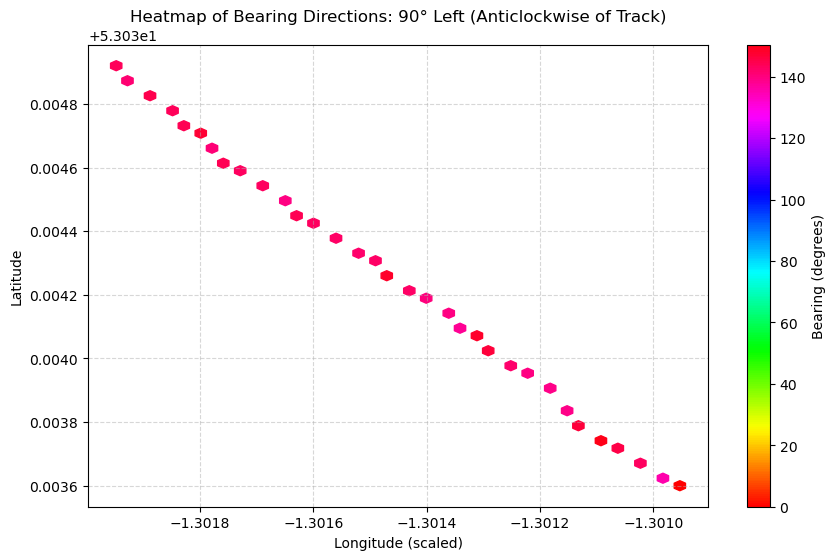

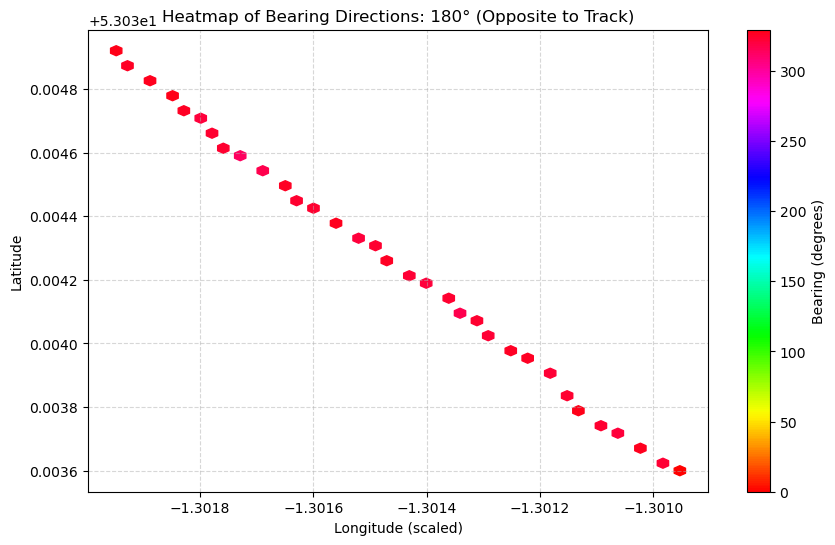

In [4]:
for orientation, bearings in bearing_data.items():
    plt.figure(figsize=(10, 6))
    plt.hexbin(df_plot['Lng_scaled'], df_plot['Lat'], C=bearings, gridsize=50, cmap='hsv', mincnt=1)
    plt.colorbar(label='Bearing (degrees)')
    plt.xlabel('Longitude (scaled)')
    plt.ylabel('Latitude')
    plt.title(f'Heatmap of Bearing Directions: {orientation}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


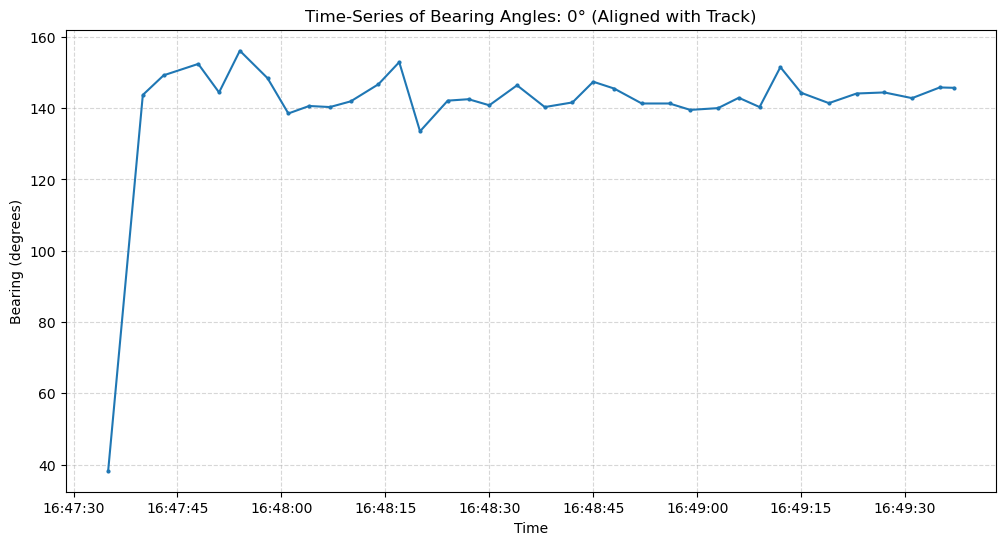

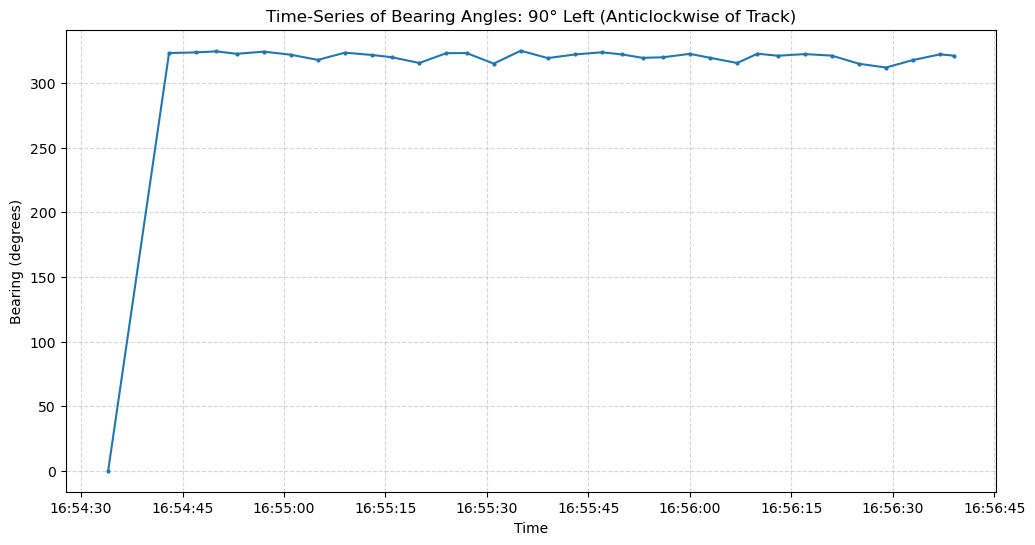

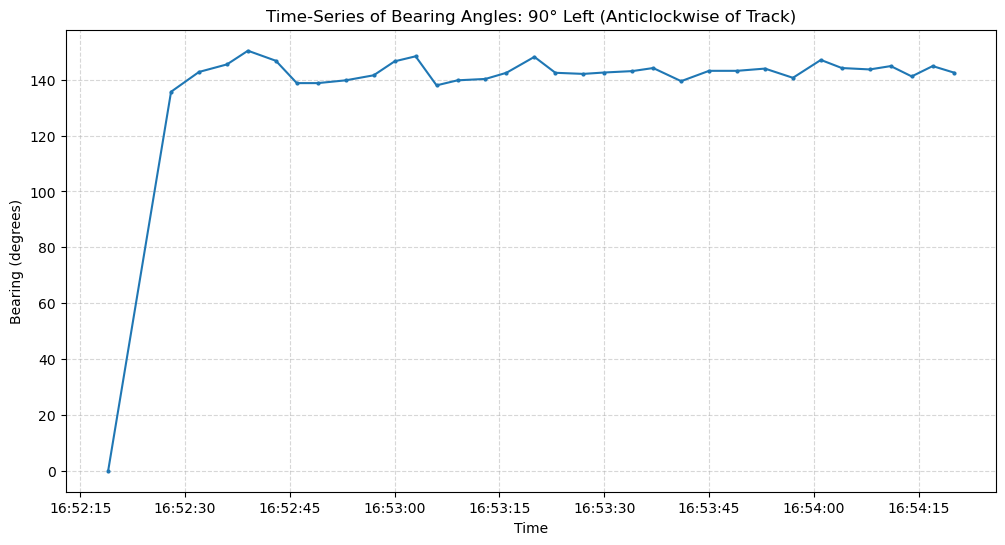

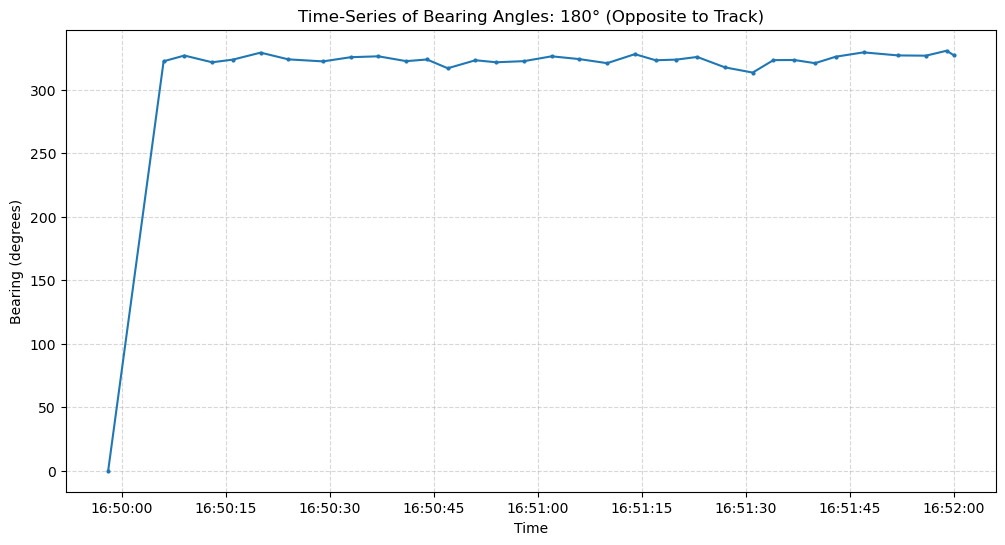

In [5]:
for filename, orientation in files_orientations.items():
    file_path = os.path.join(csv_directory, filename)
    if not os.path.isfile(file_path):
        continue
    
    df = pd.read_csv(file_path)
    if 'Time' not in df.columns:
        continue
    
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time').reset_index(drop=True)
    df = df.dropna(subset=['Bearing']).reset_index(drop=True)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Time'], df['Bearing'], marker='o', linestyle='-', markersize=2)
    plt.xlabel('Time')
    plt.ylabel('Bearing (degrees)')
    plt.title(f'Time-Series of Bearing Angles: {orientation}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


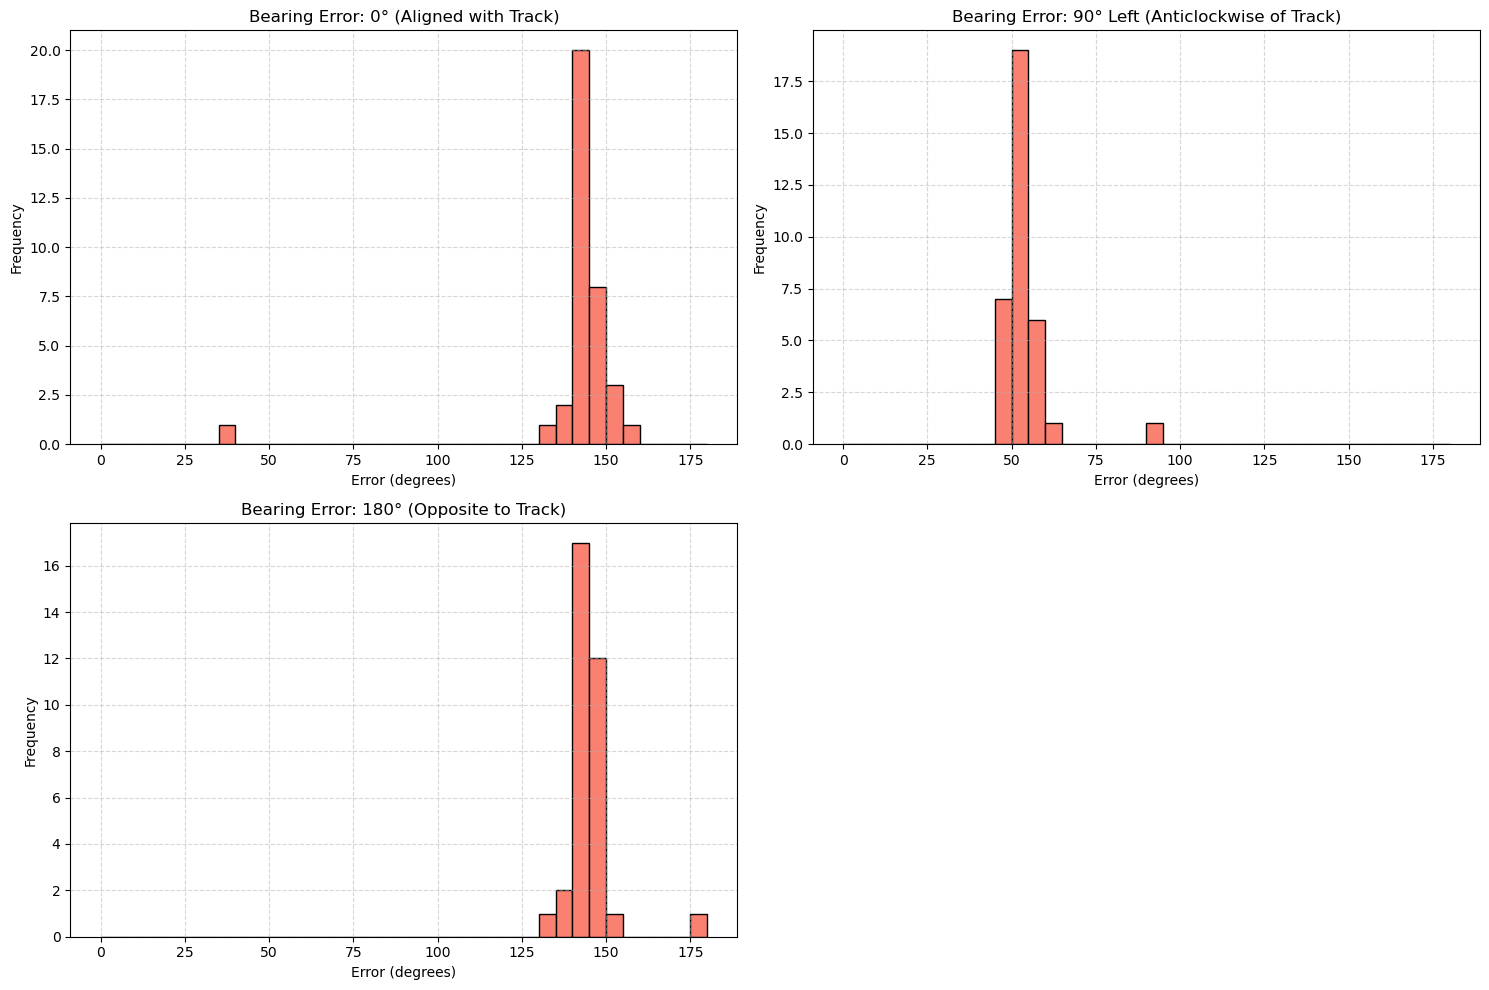

In [6]:
# Define expected bearings based on orientation
expected_bearings = {
    '0° (Aligned with Track)': 0,
    '90° Left (Anticlockwise of Track)': 90,
    '180° (Opposite to Track)': 180
}

error_data = {}
for orientation, bearings in bearing_data.items():
    if orientation in expected_bearings:
        expected = expected_bearings[orientation]
        errors = np.abs(bearings - expected)
        errors = np.minimum(errors, 360 - errors)  # Account for circular nature
        error_data[orientation] = errors

# Plot error histograms
fig_error, axes_error = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes_error = axes_error.flatten()

for idx, (orientation, errors) in enumerate(error_data.items()):
    ax = axes_error[idx]
    ax.hist(errors, bins=36, range=(0, 180), color='salmon', edgecolor='black')
    ax.set_title(f'Bearing Error: {orientation}')
    ax.set_xlabel('Error (degrees)')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(idx + 1, len(axes_error)):
    fig_error.delaxes(axes_error[j])

plt.tight_layout()
plt.show()


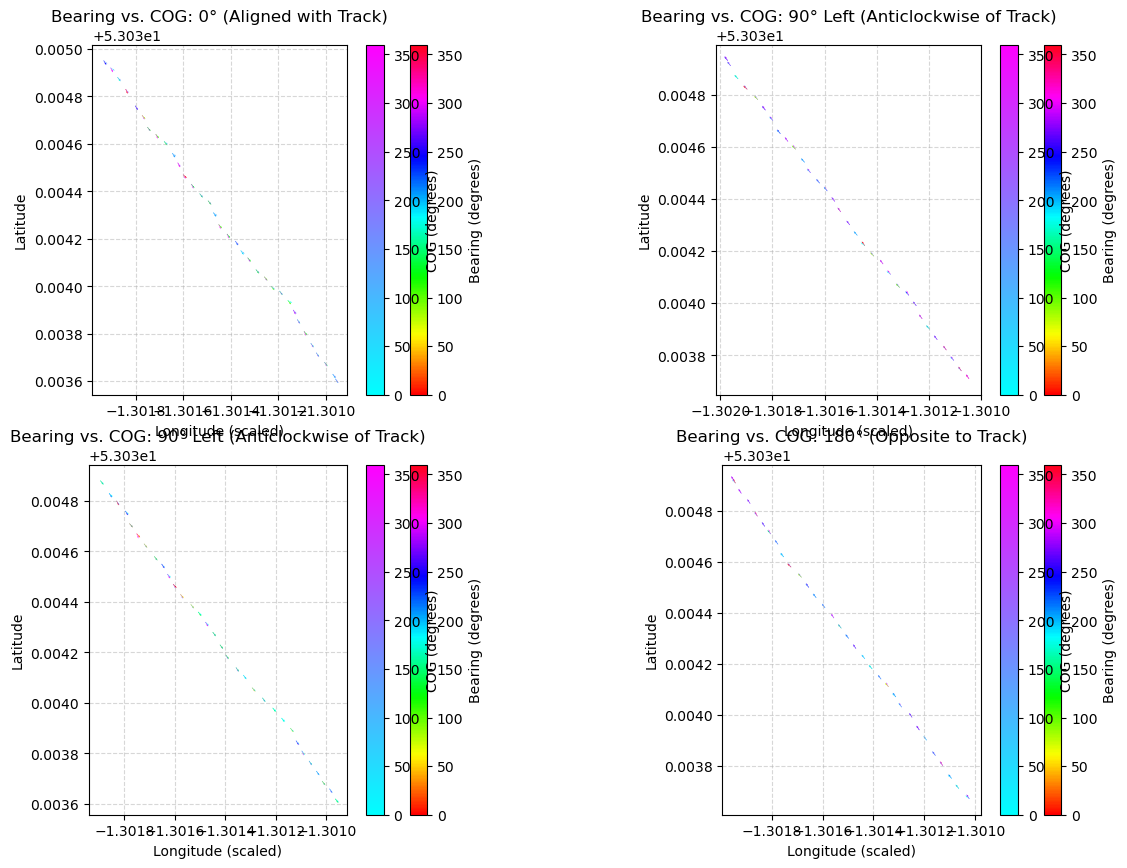

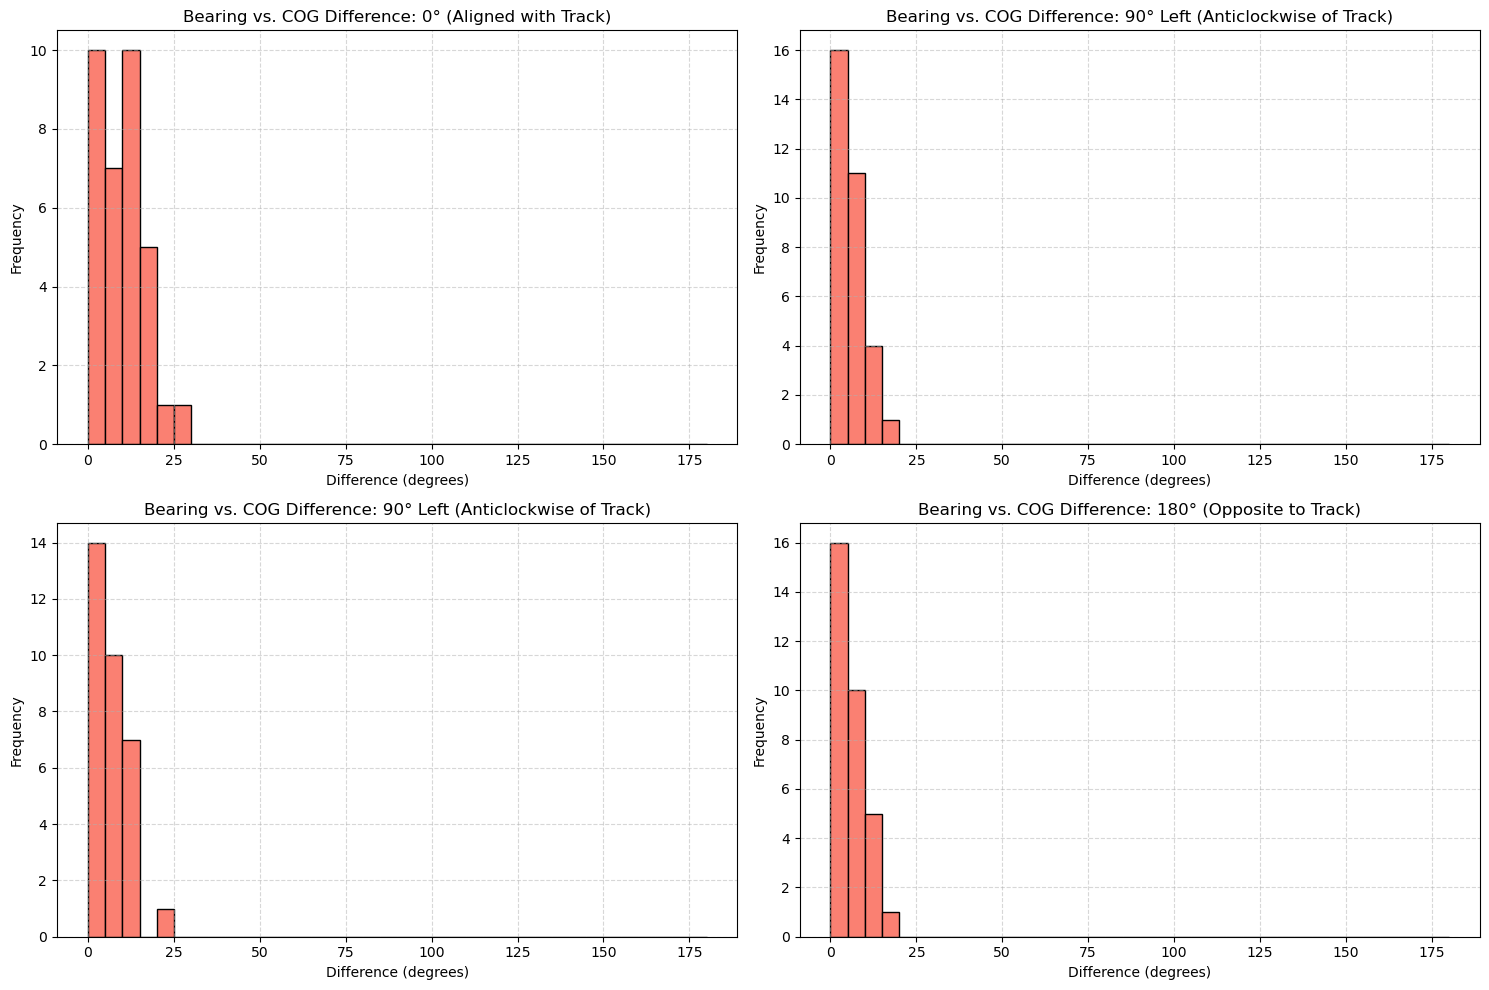

<Figure size 640x480 with 0 Axes>

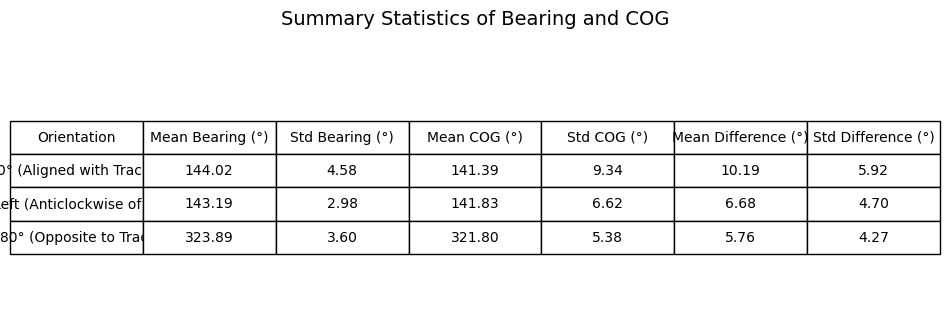

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from math import radians, degrees, sin, cos, atan2

# Function to calculate initial compass bearing between two points
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    Parameters:
        pointA: tuple of (lat, lng) in decimal degrees
        pointB: tuple of (lat, lng) in decimal degrees
    Returns:
        Initial bearing in degrees from North
    """
    if (pointA == pointB):
        return np.nan

    lat1 = radians(pointA[0])
    lat2 = radians(pointA[0])
    lat2 = radians(pointB[0])

    diffLong = radians(pointB[1] - pointA[1])

    x = sin(diffLong) * cos(lat2)
    y = cos(lat1) * sin(lat2) - (sin(lat1)
            * cos(lat2) * cos(diffLong))

    initial_bearing = atan2(x, y)

    # Convert from radians to degrees and normalize
    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

# Function to convert bearing to vector components
def bearing_to_vector(bearing_deg):
    """
    Convert bearing in degrees to vector components (u, v).
    Bearing is measured in degrees clockwise from North.
    """
    bearing_rad = np.deg2rad(bearing_deg)
    # Convert bearing to mathematical angle (counter-clockwise from East)
    angle_rad = np.pi/2 - bearing_rad
    angle_rad = np.mod(angle_rad, 2 * np.pi)
    u = np.cos(angle_rad)
    v = np.sin(angle_rad)
    return u, v

# List of CSV files and their orientations
files_orientations = {
    '0_degrees_out.csv': '0° (Aligned with Track)',
    '90_degree_left_return.csv': '90° Left (Anticlockwise of Track)',
    '90_degrees_left_out.csv': '90° Left (Anticlockwise of Track)',
    '180_degrees_return.csv': '180° (Opposite to Track)'
}

# Path to your CSV files directory
csv_directory = '.'  # Replace with your actual directory if different

# Parameters for plotting
max_arrows = 1000
scale = 50
width = 0.002
headwidth = 3
headlength = 4

# Initialize dictionaries to store data for additional visualizations
bearing_data = {}
cog_data = {}
difference_data = {}
summary_stats = {}

# Create figures for quiver plots and histograms
num_files = len(files_orientations)
cols = 2
rows = (num_files + 1) // cols

# Initialize subplots for quiver plots
fig_quiver, axes_quiver = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes_quiver = axes_quiver.flatten()

# Initialize subplots for difference histograms
fig_diff_hist, axes_diff_hist = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes_diff_hist = axes_diff_hist.flatten()

for idx, (filename, orientation) in enumerate(files_orientations.items()):
    file_path = os.path.join(csv_directory, filename)
    
    if not os.path.isfile(file_path):
        print(f"File '{filename}' not found in directory '{csv_directory}'. Skipping.")
        continue
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Check for required columns
    required_columns = ['Time', 'Lat', 'Lng', 'Bearing']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the CSV file '{filename}'.")
    
    # Drop rows with missing values in required columns
    df = df.dropna(subset=required_columns).reset_index(drop=True)
    
    # Sort the data by time to ensure chronological order
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time').reset_index(drop=True)
    
    # Calculate COG
    cog = []
    for i in range(len(df)):
        if i == 0:
            cog.append(np.nan)  # First point has no previous point to calculate COG
        else:
            pointA = (df.loc[i-1, 'Lat'], df.loc[i-1, 'Lng'])
            pointB = (df.loc[i, 'Lat'], df.loc[i, 'Lng'])
            bearing = calculate_initial_compass_bearing(pointA, pointB)
            cog.append(bearing)
    
    df['COG'] = cog
    
    # Calculate the difference between Bearing and COG
    # Align Bearing to the current point's movement
    # Since COG is calculated based on movement from i-1 to i, we shift COG to align with bearing at i
    df['COG_shifted'] = df['COG'].shift(1)
    df['Difference'] = np.abs(df['Bearing'] - df['COG_shifted'])
    df['Difference'] = df['Difference'].apply(lambda x: min(x, 360 - x))  # Ensure the difference is <=180
    
    # Drop the first row with NaN COG_shifted
    df = df.dropna(subset=['COG_shifted']).reset_index(drop=True)
    
    # Optional: Downsample the data for better visualization if the dataset is large
    step = max(1, len(df) // max_arrows)
    df_plot = df.iloc[::step, :]
    
    # Store bearing and COG data
    bearing_data[orientation] = df_plot['Bearing'].values
    cog_data[orientation] = df_plot['COG_shifted'].values
    difference_data[orientation] = df_plot['Difference'].values
    
    # Calculate summary statistics
    summary_stats[orientation] = {
        'Mean Bearing': np.mean(df_plot['Bearing']),
        'Std Bearing': np.std(df_plot['Bearing']),
        'Mean COG': np.mean(df_plot['COG_shifted']),
        'Std COG': np.std(df_plot['COG_shifted']),
        'Mean Difference': np.mean(df_plot['Difference']),
        'Std Difference': np.std(df_plot['Difference'])
    }
    
    # Convert bearings and COG to vectors
    u_bearing, v_bearing = bearing_to_vector(df_plot['Bearing'].values)
    u_cog, v_cog = bearing_to_vector(df_plot['COG_shifted'].values)
    
    # Apply scaling to longitude to account for latitude
    df_plot['Lng_scaled'] = df_plot['Lng'] * np.cos(np.deg2rad(df_plot['Lat']))
    
    # Plot quiver for Bearing
    ax = axes_quiver[idx]
    quiver_bearing = ax.quiver(
        df_plot['Lng_scaled'], 
        df_plot['Lat'], 
        u_bearing, 
        v_bearing, 
        df_plot['Bearing'],
        cmap='hsv',
        scale=scale,
        width=width,
        headwidth=headwidth,
        headlength=headlength,
        label='Bearing'
    )
    
    # Overlay quiver for COG
    quiver_cog = ax.quiver(
        df_plot['Lng_scaled'], 
        df_plot['Lat'], 
        u_cog, 
        v_cog, 
        df_plot['COG_shifted'],
        cmap='cool',
        scale=scale,
        width=width,
        headwidth=headwidth,
        headlength=headlength,
        label='COG',
        alpha=0.7
    )
    
    ax.set_xlabel('Longitude (scaled)')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Bearing vs. COG: {orientation}')
    
    # Create a combined color bar
    # Normalize the color for bearing and COG
    norm = plt.Normalize(0, 360)
    sm_bearing = plt.cm.ScalarMappable(cmap='hsv', norm=norm)
    sm_bearing.set_array([])
    sm_cog = plt.cm.ScalarMappable(cmap='cool', norm=norm)
    sm_cog.set_array([])
    
    # Add color bars
    cbar_bearing = fig_quiver.colorbar(sm_bearing, ax=ax, fraction=0.046, pad=0.04)
    cbar_bearing.set_label('Bearing (degrees)')
    
    cbar_cog = fig_quiver.colorbar(sm_cog, ax=ax, fraction=0.046, pad=0.04)
    cbar_cog.set_label('COG (degrees)')
    
    # Set aspect ratio to equal
    ax.set_aspect('equal', adjustable='box')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Plot difference histogram
    ax_hist = axes_diff_hist[idx]
    ax_hist.hist(df_plot['Difference'], bins=36, range=(0, 180), color='salmon', edgecolor='black')
    ax_hist.set_title(f'Bearing vs. COG Difference: {orientation}')
    ax_hist.set_xlabel('Difference (degrees)')
    ax_hist.set_ylabel('Frequency')
    ax_hist.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots in quiver plots
for j in range(idx + 1, len(axes_quiver)):
    fig_quiver.delaxes(axes_quiver[j])

plt.tight_layout()
plt.show()

# Hide any unused subplots in difference histograms
for j in range(idx + 1, len(axes_diff_hist)):
    fig_diff_hist.delaxes(axes_diff_hist[j])

plt.tight_layout()
plt.show()

# Additional Visualization: Summary Statistics Table
import matplotlib.table as tbl

fig_table, ax_table = plt.subplots(figsize=(12, 2 + len(summary_stats) * 0.5))
ax_table.axis('off')  # Hide the axes

# Prepare table data
table_data = []
for orientation, stats in summary_stats.items():
    table_data.append([
        orientation, 
        f"{stats['Mean Bearing']:.2f}", 
        f"{stats['Std Bearing']:.2f}",
        f"{stats['Mean COG']:.2f}",
        f"{stats['Std COG']:.2f}",
        f"{stats['Mean Difference']:.2f}",
        f"{stats['Std Difference']:.2f}"
    ])

# Define table column labels
column_labels = [
    "Orientation", 
    "Mean Bearing (°)", 
    "Std Bearing (°)",
    "Mean COG (°)",
    "Std COG (°)",
    "Mean Difference (°)",
    "Std Difference (°)"
]

# Create the table using the Axes method
table = ax_table.table(
    cellText=table_data,
    colLabels=column_labels,
    loc='center',
    cellLoc='center'
)

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.title('Summary Statistics of Bearing and COG', fontsize=14, pad=20)
plt.show()


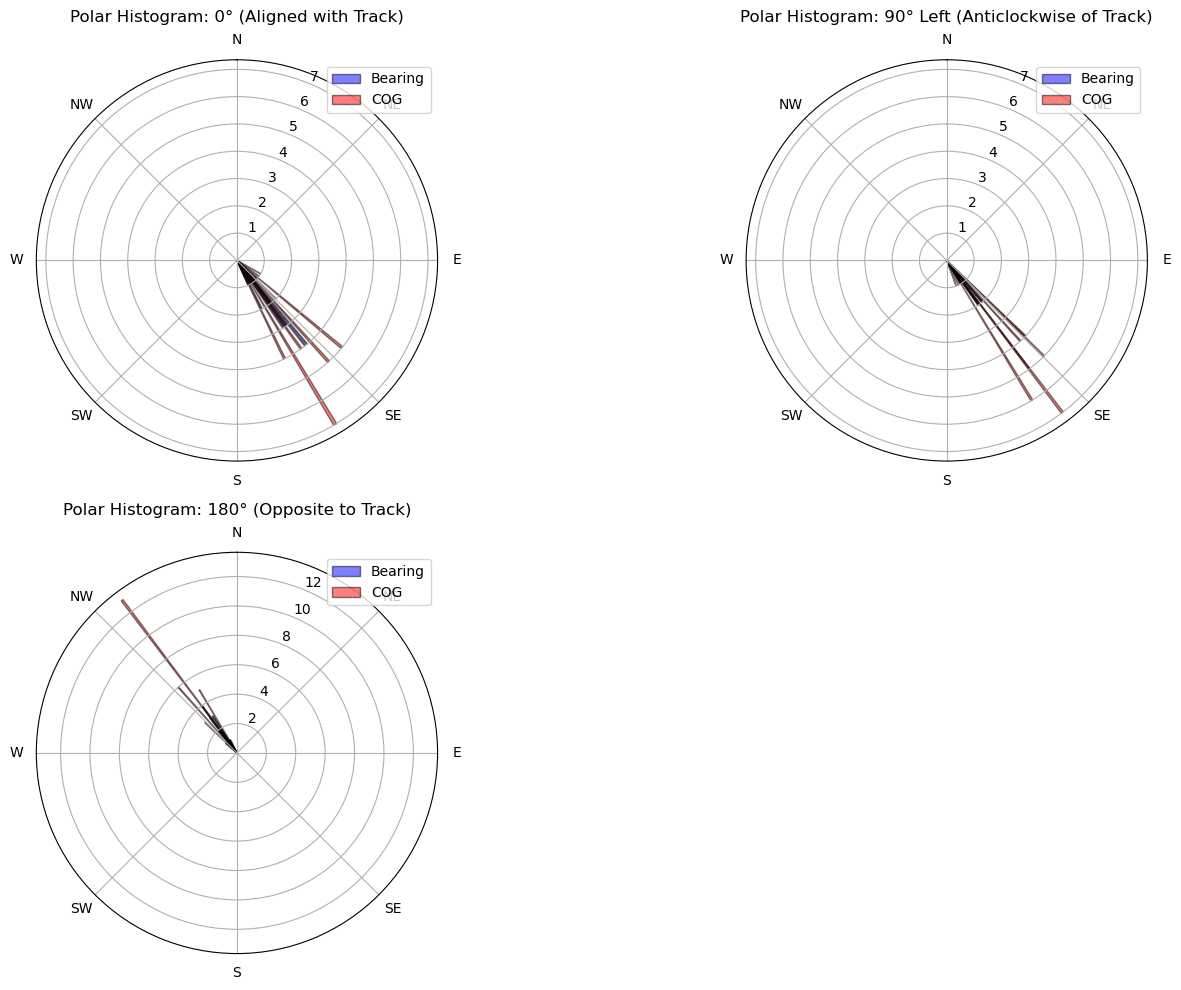

In [20]:
fig_polar, axes_polar = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(15, 5 * rows))
axes_polar = axes_polar.flatten()

for idx, (orientation, bearings) in enumerate(bearing_data.items()):
    cog_angles = cog_data[orientation]
    differences = difference_data[orientation]
    
    ax = axes_polar[idx]
    
    # Convert degrees to radians for polar plot
    bearings_rad = np.deg2rad(bearings)
    cog_rad = np.deg2rad(cog_angles)
    
    # Plot histogram for Bearing
    ax.hist(bearings_rad, bins=36, alpha=0.5, label='Bearing', color='blue', edgecolor='black')
             # , edgecolor='black')
    
    # Plot histogram for COG
    ax.hist(cog_rad, bins=36, alpha=0.5, label='COG', color='red', edgecolor='black')
    
    ax.set_title(f'Polar Histogram: {orientation}', va='bottom')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax.legend(loc='upper right')
    
# Hide any unused subplots
for j in range(idx + 1, len(axes_polar)):
    fig_polar.delaxes(axes_polar[j])

plt.tight_layout()
plt.show()


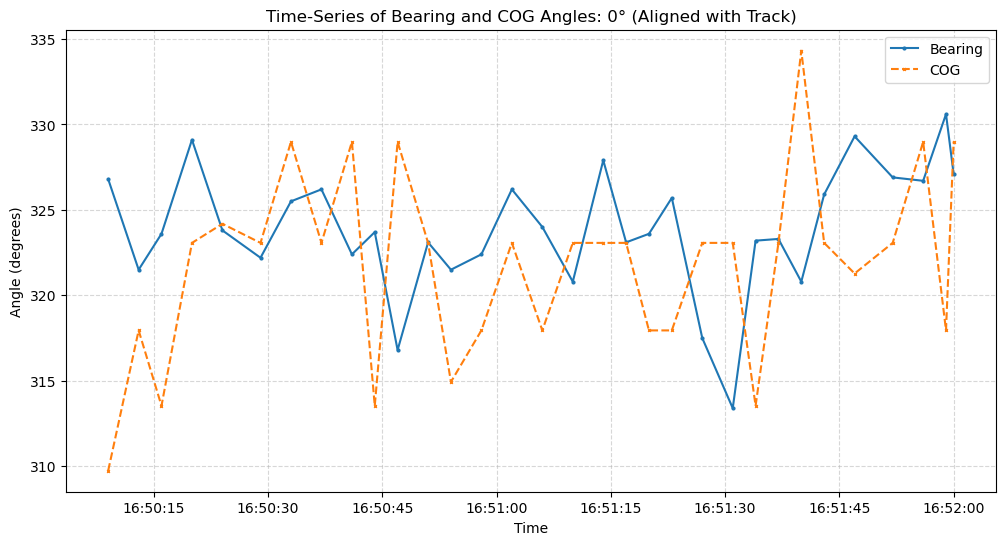

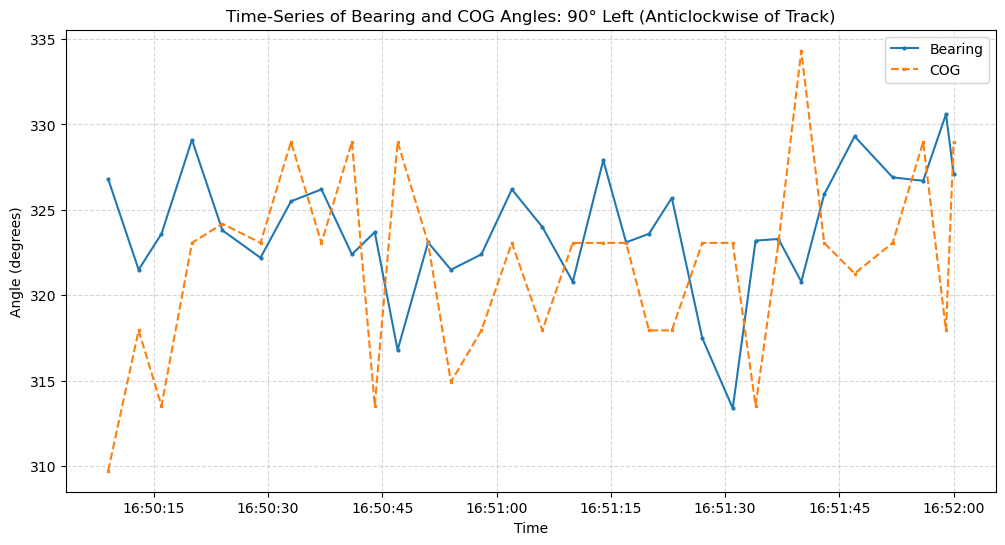

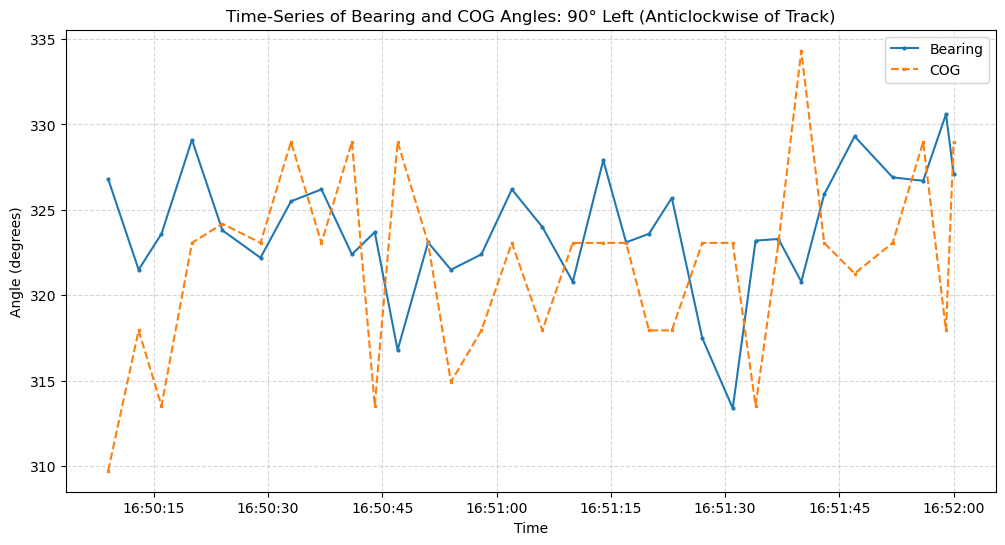

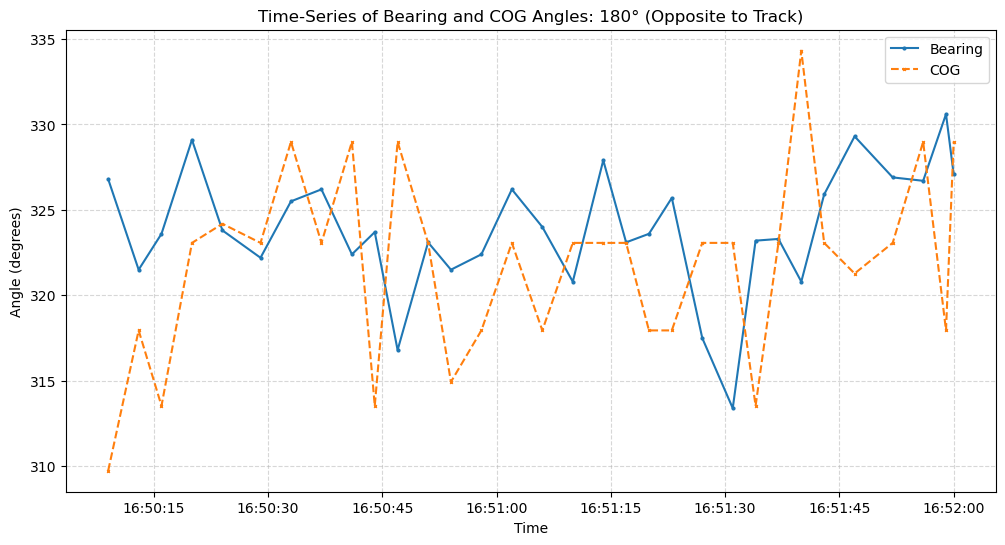

In [17]:
for filename, orientation in files_orientations.items():
    file_path = os.path.join(csv_directory, filename)
    if not os.path.isfile(file_path):
        continue
    
    df = pd.read_csv(file_path)
    # ... [Process as above to obtain df_plot]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot['Time'], df_plot['Bearing'], marker='o', linestyle='-', markersize=2, label='Bearing')
    plt.plot(df_plot['Time'], df_plot['COG_shifted'], marker='x', linestyle='--', markersize=2, label='COG')
    plt.xlabel('Time')
    plt.ylabel('Angle (degrees)')
    plt.title(f'Time-Series of Bearing and COG Angles: {orientation}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


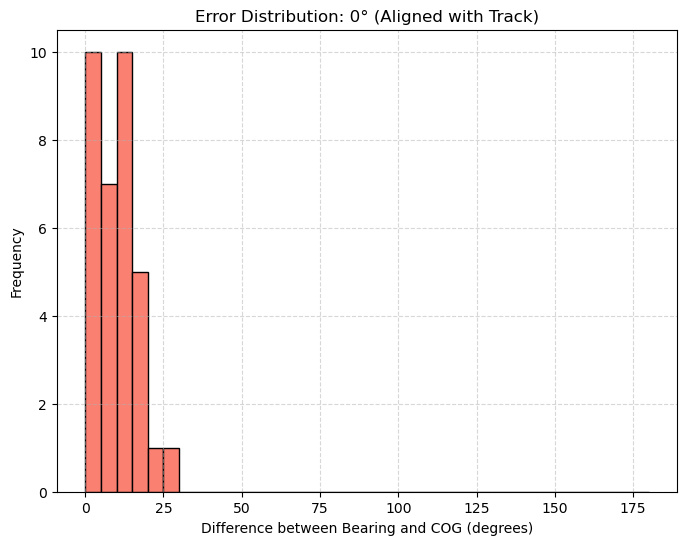

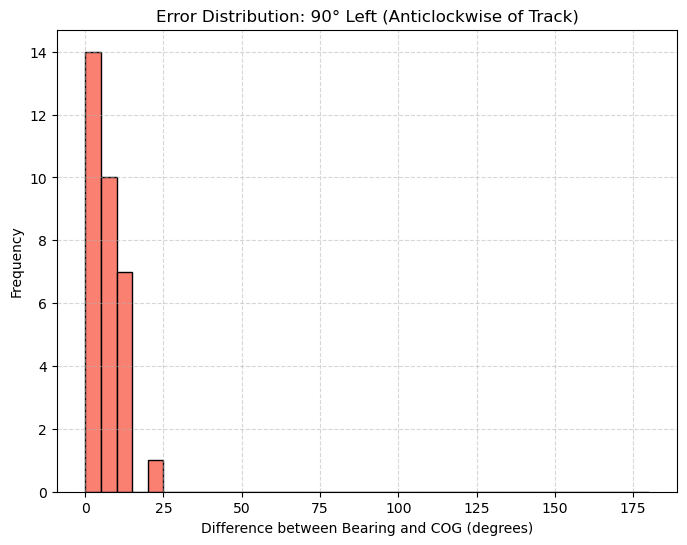

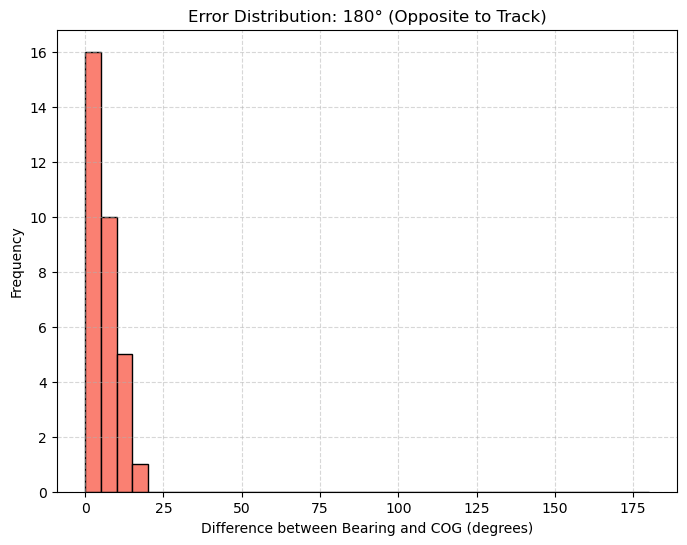

In [18]:
for orientation, differences in difference_data.items():
    plt.figure(figsize=(8, 6))
    plt.hist(differences, bins=36, range=(0, 180), color='salmon', edgecolor='black')
    plt.xlabel('Difference between Bearing and COG (degrees)')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution: {orientation}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


In [19]:
import folium

# Initialize a Folium map centered at the mean latitude and longitude
all_lats = []
all_lngs = []
for filename in files_orientations.keys():
    file_path = os.path.join(csv_directory, filename)
    if not os.path.isfile(file_path):
        continue
    df = pd.read_csv(file_path)
    all_lats.extend(df['Lat'].dropna().values)
    all_lngs.extend(df['Lng'].dropna().values)

mean_lat = np.mean(all_lats) if all_lats else 0
mean_lng = np.mean(all_lngs) if all_lngs else 0

m = folium.Map(location=[mean_lat, mean_lng], zoom_start=12)

for filename, orientation in files_orientations.items():
    file_path = os.path.join(csv_directory, filename)
    if not os.path.isfile(file_path):
        continue
    
    df = pd.read_csv(file_path)
    # ... [Process as above to obtain df_plot]
    
    # Add bearing vectors
    for _, row in df_plot.iterrows():
        folium.PolyLine(
            locations=[
                [row['Lat'], row['Lng']],
                [row['Lat'] + (sin(np.deg2rad(row['Bearing'])) * 0.001), 
                 row['Lng'] + (cos(np.deg2rad(row['Bearing'])) * 0.001)]
            ],
            color='blue',
            weight=1,
            opacity=0.6,
            tooltip=f'Bearing: {row["Bearing"]:.1f}°'
        ).add_to(m)
    
    # Add COG vectors
    for _, row in df_plot.iterrows():
        folium.PolyLine(
            locations=[
                [row['Lat'], row['Lng']],
                [row['Lat'] + (sin(np.deg2rad(row['COG_shifted'])) * 0.001), 
                 row['Lng'] + (cos(np.deg2rad(row['COG_shifted'])) * 0.001)]
            ],
            color='red',
            weight=1,
            opacity=0.6,
            tooltip=f'COG: {row["COG_shifted"]:.1f}°'
        ).add_to(m)

# Save the interactive map to an HTML file
m.save('interactive_bearing_cog_map.html')
print("Interactive map saved as 'interactive_bearing_cog_map.html'. Open it in a web browser to view.")


Interactive map saved as 'interactive_bearing_cog_map.html'. Open it in a web browser to view.
